In [12]:
from idlelib.window import add_windows_to_menu

import pandas as pd
from requests.packages import target
from rockfish import LogLevel


def sessionise_data(df, start_session =1):
    # Ensure the timestamp is in datetime format
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Sort the dataframe by timestamp
    df = df.sort_values(by='timestamp').reset_index(drop=True)
    
    def generate_sessions(df, window_size=24, step_size=1):
        sessions = []
        start_time = df['timestamp'].min()
        end_time = df['timestamp'].max()
        
        current_time = start_time
        session_id = 1
        
        while current_time + pd.Timedelta(hours=window_size) <= end_time:
            session_df = df[(df['timestamp'] >= current_time) & (df['timestamp'] < current_time + pd.Timedelta(hours=window_size))].copy()
            session_df['sessionID'] = session_id
            sessions.append(session_df)
            
            current_time += pd.Timedelta(hours=step_size)
            session_id += 1
        
        return pd.concat(sessions, ignore_index=True)
    
    # Generate sessions
    sessions_df = generate_sessions(df)
    return sessions_df

In [54]:
actions = pickle.load(open('runtime_conf.pkl', 'rb'))
actions.actions['train-time-gan'].config()

Config(
    doppelganger=DGConfig(
        sample_len=2,
        activate_normalization_per_sample=True,
        generator_attribute_num_layers=5,
        generator_feature_num_layers=1,
        epoch=400,
        epoch_checkpoint_freq=10,
        batch_size=116,
        g_lr=0.0001,
        d_lr=0.0001,
        attr_d_beta1=0.5,
        sessions=696,
        extras={}
    ),
    encoder=DatasetConfig(
        name='default',
        metadata=[
            FieldConfig(
                field='sessionID',
                type='continuous',
                semantic_type=None
            )
        ],
        measurements=[
            FieldConfig(
                field='feature_13',
                type='continuous',
                semantic_type=None
            )
        ],
        timestamp=TimestampConfig(field='timestamp', unit='ms', strptime=None),
        privacy=None,
        embedding=None,
        group_by=None,
        timeseries=None
    ),
    model_ids=None
)

In [47]:
import pickle
import rockfish as rf

actions = pickle.load(open('runtime_conf.pkl', 'rb'))
conn = rf.Connection.from_config()

builder = rf.WorkflowBuilder()
builder.add_path(rf.Dataset.from_csv('demo_dt', 'test/location3.csv'), actions.actions['train-time-gan'])
workflow = await builder.start(conn)
workflow.id()

'4DEKWqmJVAi1wfEKo7EhmX'

In [48]:
async for log in workflow.logs(level=rf.LogLevel.DEBUG):
    print(log)

2024-10-02T18:49:37Z dataset-load: INFO Loading dataset '3FQsYKiPc2dhzJWF8RUnuQ' with 12959 rows
2024-10-02T18:49:37Z train-time-gan: DEBUG CUDA not available
2024-10-02T18:49:37Z train-time-gan: ERROR Internal error occurred while running the action. Please contact support@rockfish.ai


In [43]:
import rockfish as rf
conn = rf.Connection.from_config()
model = await conn.list_models().last()
model

Model(id='78489743-8027-11ef-9e39-ce6cd7fc8a2f', labels={'workflow_id': '26QpsZQbnNAyHrGXcfEhpz'}, create_time=datetime.datetime(2024, 10, 1, 19, 0, 48, tzinfo=datetime.timezone.utc), size_bytes=773852160)

In [49]:
builder = rf.WorkflowBuilder()
import rockfish.actions as ra
conn_local = rf.Connection.local()
gen = ra.GenerateTimeGAN()
gen.config().doppelganger.sessions = 300
builder.add_path(model, gen, ra.DatasetSave(name='synthetic_data'))
workflow = await builder.start(conn)
workflow.id()

'5TXllf0hCRMUz9YSNPUhgO'

In [50]:
async for log in workflow.logs(level=rf.LogLevel.DEBUG):
    print(log)

2024-10-01T19:04:24Z generate-time-gan: DEBUG CUDA available
2024-10-01T19:04:24Z generate-time-gan: DEBUG Running on cuda:NVIDIA A100 80GB PCIe with cuda version 11.8
2024-10-01T19:04:24Z generate-time-gan: INFO Downloading model with model_id='78489743-8027-11ef-9e39-ce6cd7fc8a2f'...
2024-10-01T19:05:07Z generate-time-gan: INFO Generating 300 sessions...
2024-10-01T19:05:07Z generate-time-gan: DEBUG Generating data from model trained with 400 epochs
2024-10-01T19:05:08Z generate-time-gan: DEBUG DG generating 3 batches
2024-10-01T19:05:08Z dataset-save: INFO using field 'session_key' to concatenate tables
2024-10-01T19:05:08Z dataset-save: INFO Saved dataset '7EyXBb2oo0SWany8nIj7q0' with 12220 rows


In [51]:
syn = await (await workflow.datasets().last()).to_local(conn)

In [52]:
syn.to_pandas()

,timestamp,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,session_key
0,2023-08-11 17:45:29.858,0.743775,0.739928,0.553015,0.504247,0.434376,0.377533,0.451454,0.501793,0.406757,...,0.391676,0.571217,0.378163,0.585993,0.028138,0.012182,0.210496,0.146738,0.176767,0.0
1,2023-08-11 17:46:17.853,0.748679,0.771635,0.546615,0.513607,0.473839,0.436898,0.464028,0.522947,0.403598,...,0.450299,0.581647,0.400623,0.634794,0.030192,0.015059,0.216867,0.169075,0.173937,0.0
2,2023-08-11 17:46:59.447,0.753074,0.745576,0.542101,0.512637,0.428325,0.372761,0.481765,0.472585,0.403362,...,0.404311,0.572979,0.390519,0.620915,0.020689,0.007702,0.203235,0.149445,0.169989,0.0
3,2023-08-11 17:47:46.101,0.728998,0.728102,0.552418,0.512928,0.449804,0.393011,0.470144,0.503008,0.425315,...,0.427691,0.570616,0.373299,0.598019,0.020219,0.010133,0.213074,0.149371,0.172481,0.0
4,2023-08-11 17:48:24.155,0.760513,0.732318,0.547497,0.510298,0.438494,0.387712,0.443159,0.521591,0.422987,...,0.452018,0.575668,0.381024,0.626848,0.020990,0.009654,0.207390,0.149048,0.168949,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12215,2023-08-12 07:35:50.380,0.788435,0.744413,0.568869,0.536014,0.392638,0.405175,0.448745,0.418443,0.378811,...,0.399989,0.572596,0.321561,0.592512,0.022526,0.008747,0.199671,0.130119,0.157239,299.0
12216,2023-08-12 07:36:26.989,0.800033,0.747428,0.571090,0.548128,0.402471,0.438019,0.437782,0.388827,0.381272,...,0.391165,0.568946,0.310666,0.588857,0.021378,0.009178,0.197656,0.132575,0.153178,299.0
12217,2023-08-12 07:37:03.588,0.781050,0.740440,0.571230,0.538363,0.393750,0.413550,0.465575,0.403186,0.386472,...,0.396799,0.577317,0.309316,0.597653,0.021600,0.008427,0.197181,0.143216,0.148328,299.0
12218,2023-08-12 07:37:38.134,0.791409,0.746348,0.576895,0.529996,0.397531,0.425977,0.445000,0.407673,0.386990,...,0.405383,0.589165,0.313388,0.590919,0.026496,0.014135,0.208790,0.139149,0.150681,299.0


In [53]:
syn.to_pandas().to_csv('test/syn_data.csv', index=False)

In [34]:
import pandas as pd
l1 = pd.read_csv('location1.csv')

In [41]:
l1=l1[['feature_13','timestamp','sessionID']]
l1['sessionID'] = l1['sessionID'].apply(lambda x: str(x))

In [42]:
l2 = pd.read_csv('location2.csv')
l2=l2[['feature_13','timestamp','sessionID']]
l2['sessionID'] = l2['sessionID'].apply(lambda x: str(x))

In [43]:
l3 = pd.read_csv('location3.csv')
l3=l3[['feature_13','timestamp','sessionID']]
l3['sessionID'] = l3['sessionID'].apply(lambda x: str(x))

In [38]:
syn = pd.read_csv('syn_data.csv')
syn = syn.drop_duplicates(subset=['timestamp'])

In [44]:
l1.to_csv('test/location1.csv', index=False)
l2.to_csv('test/location2.csv', index=False)
l3.to_csv('test/location3.csv', index=False)
# syn.to_csv('test/syn_data.csv', index=False)

In [14]:
import check
import pickle
import rockfish as rf

In [17]:
data = rf.Dataset.from_csv('data', 'location3.csv')
syn = rf.Dataset.from_csv('syn', 'syn_data.csv')

In [5]:
actions = pickle.load(open('runtime_conf.pkl', 'rb'))

In [8]:
config = actions.actions['train-time-gan'].config()

/Users/deepanshu/rockfish/rockfish-sdk/sdk-cuddlefish-venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/deepanshu/rockfish/rockfish-sdk/sdk-cuddlefish-venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/deepanshu/rockfish/rockfish-sdk/sdk-cuddlefish-venv/lib/python3.11/site-packages/rockfish/labs/vis.py:170: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  fg = sns.displot(
/Users/deepanshu/rockfish/rockfish-sdk/sdk-cuddlefish-venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

Comparison,Source,Synthetic
Total Columns,27,27
Total Rows,12959,12220

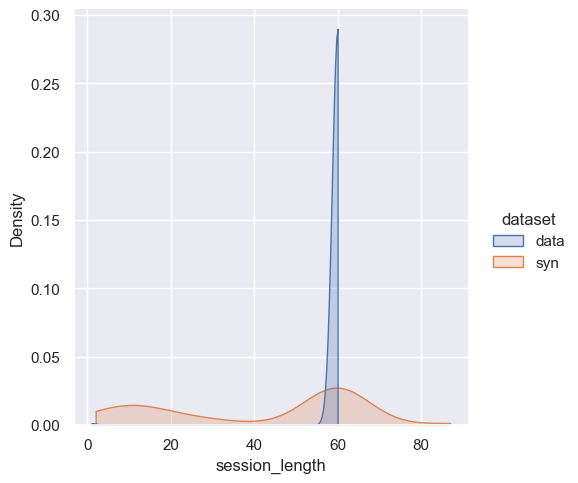
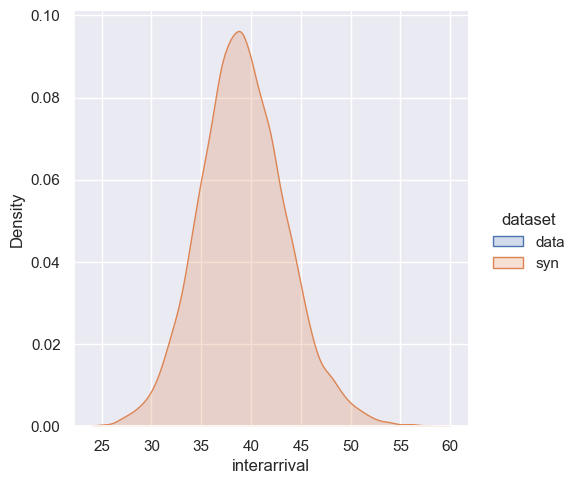
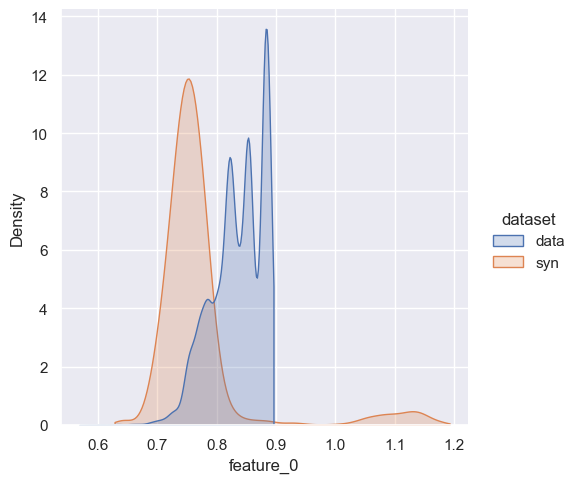
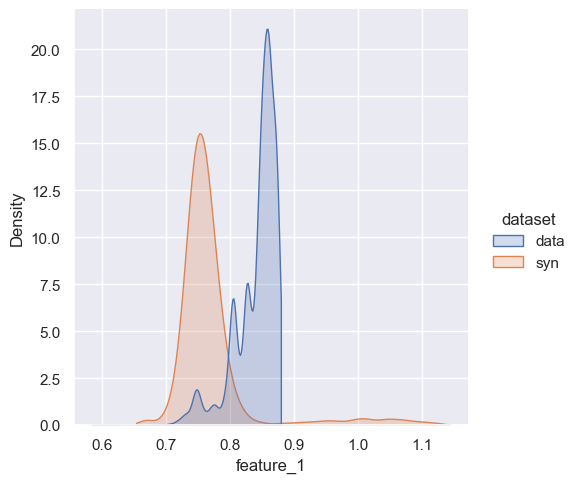
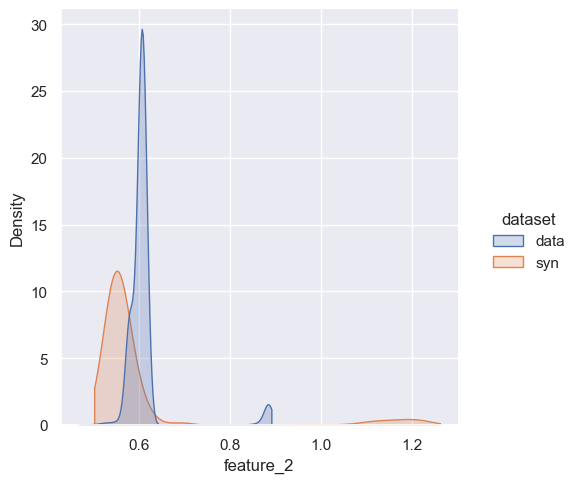
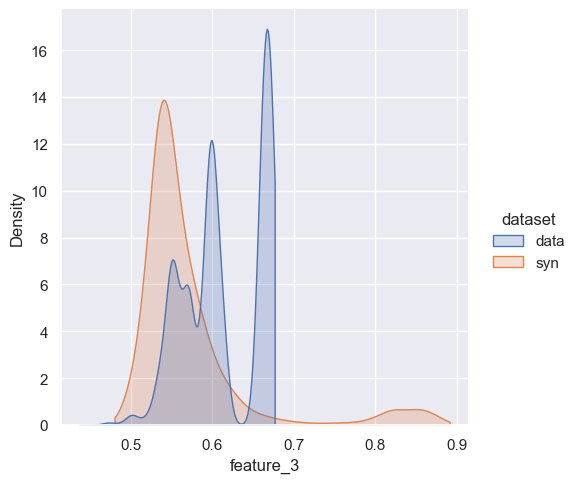
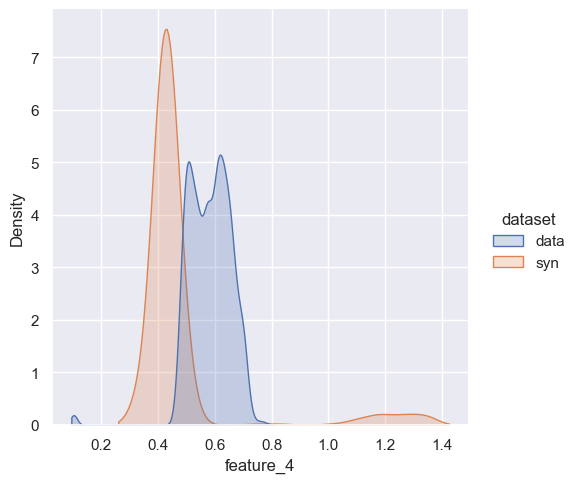
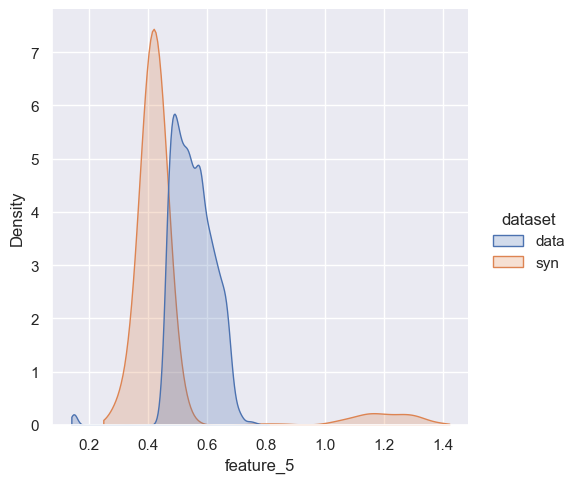
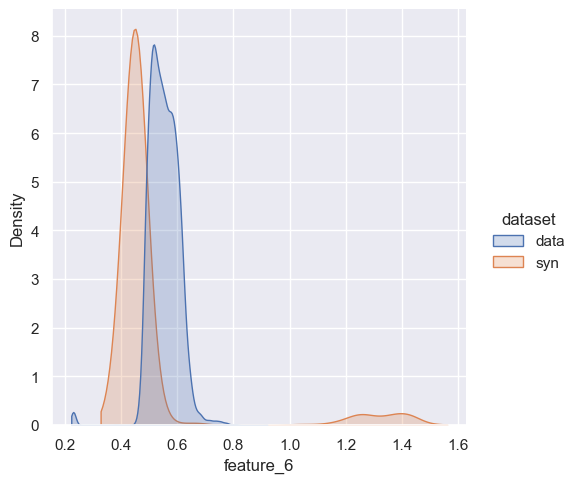
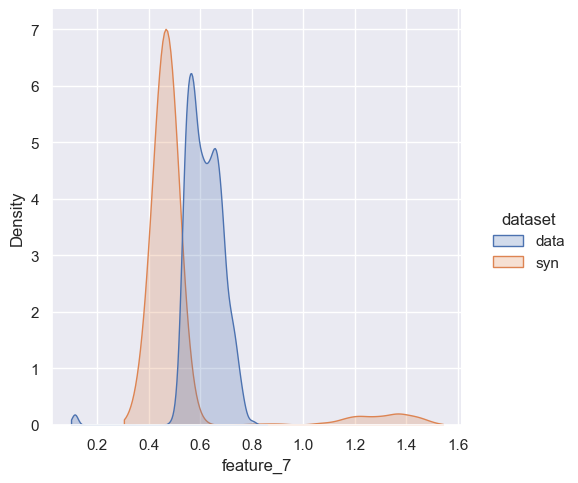
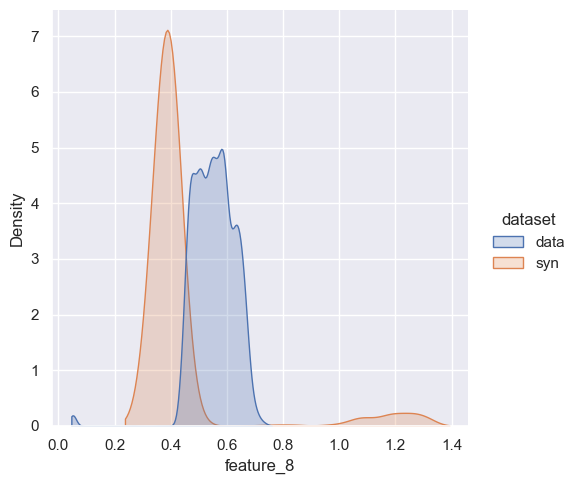
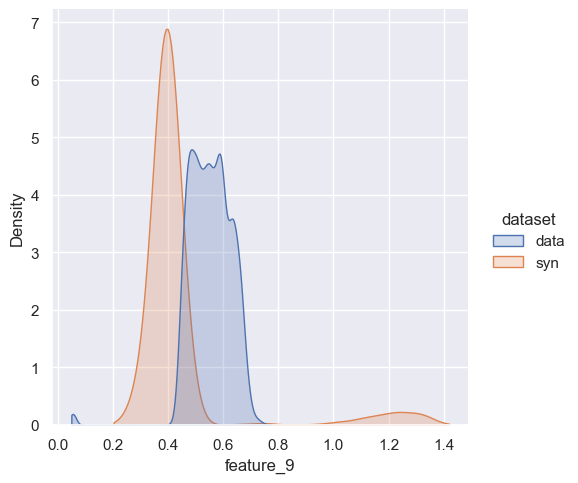
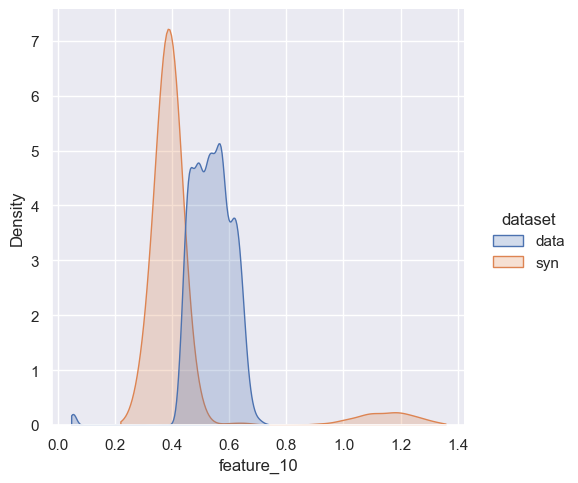
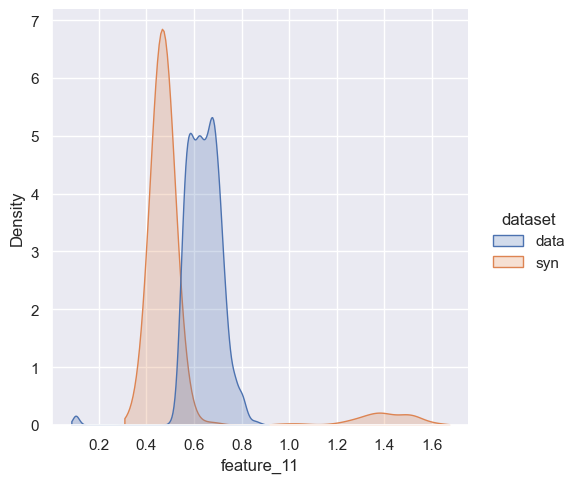
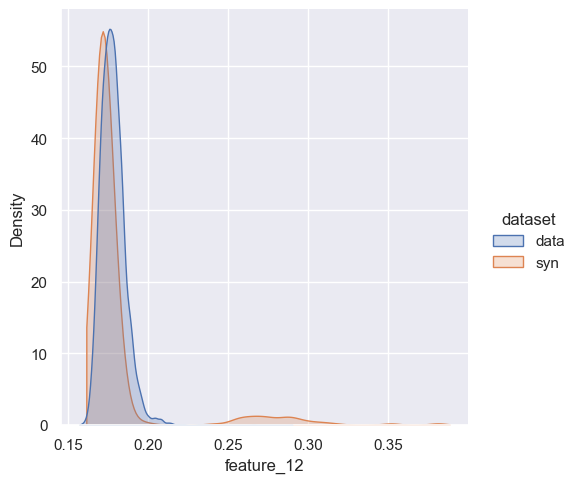
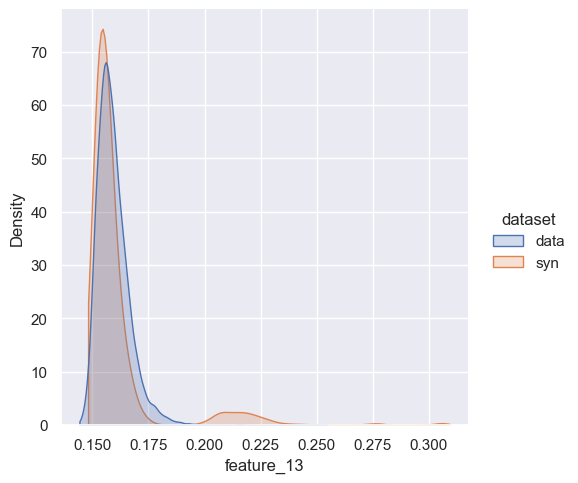
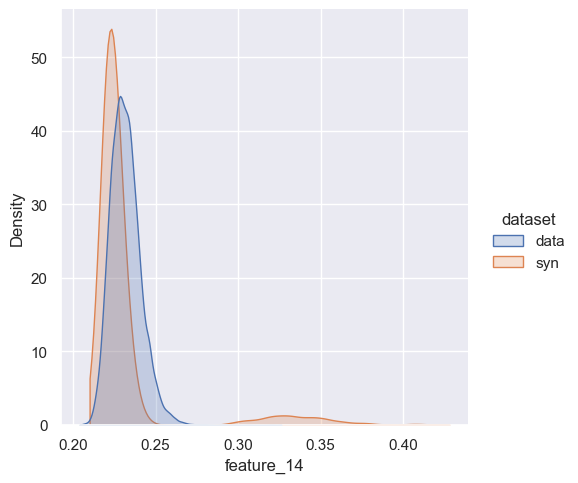
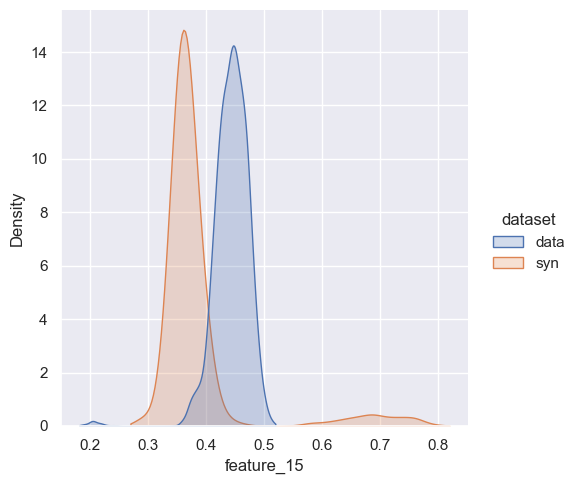
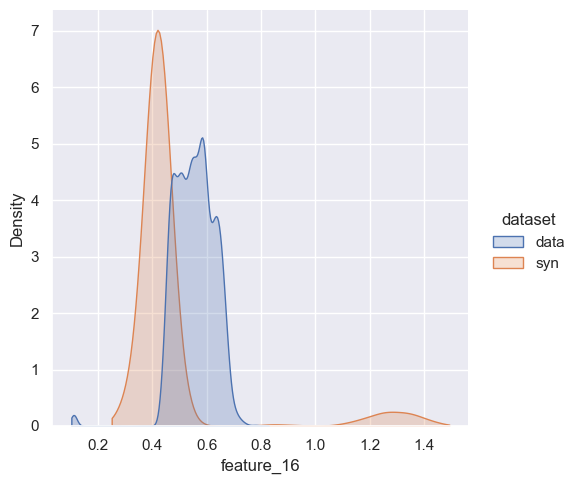
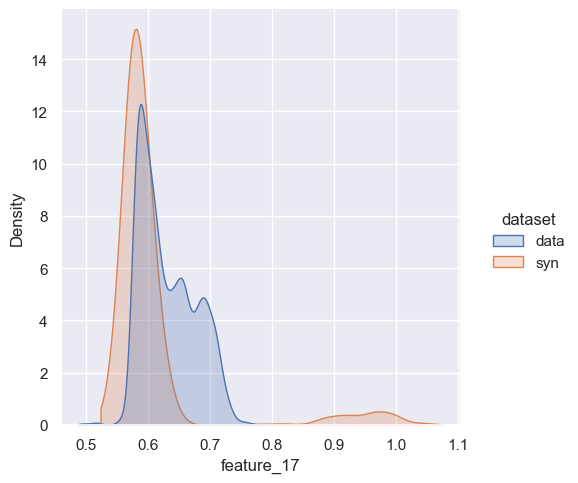
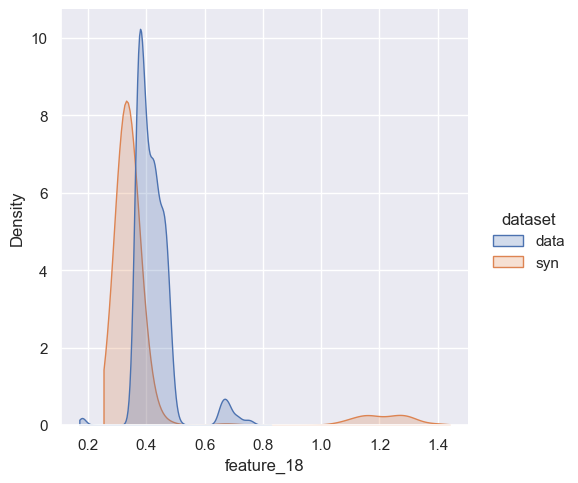
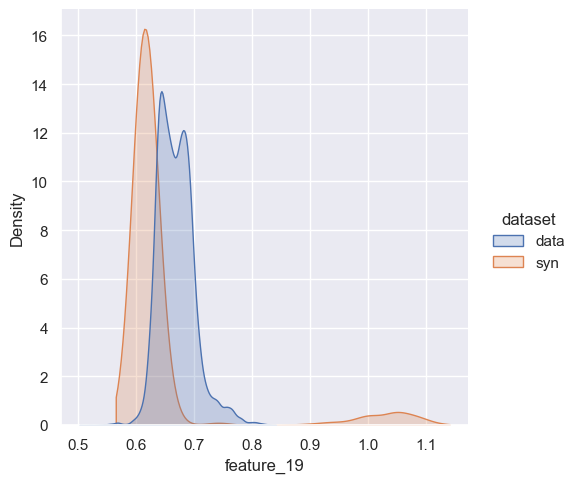
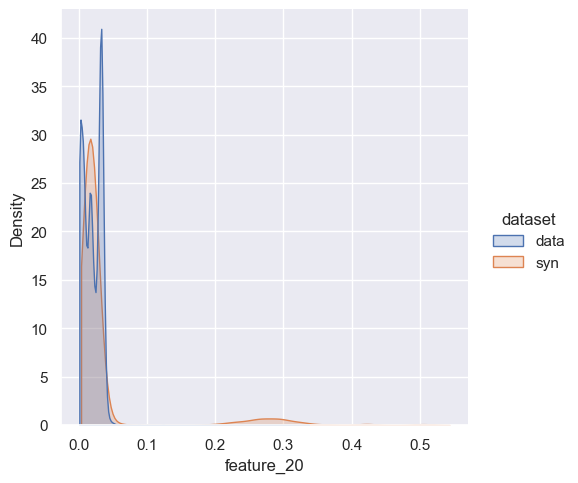
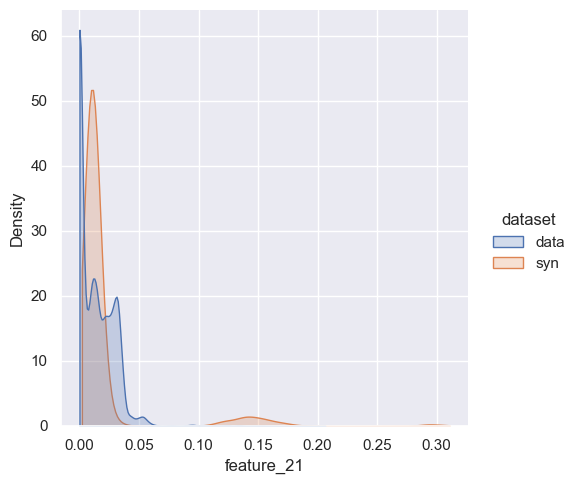
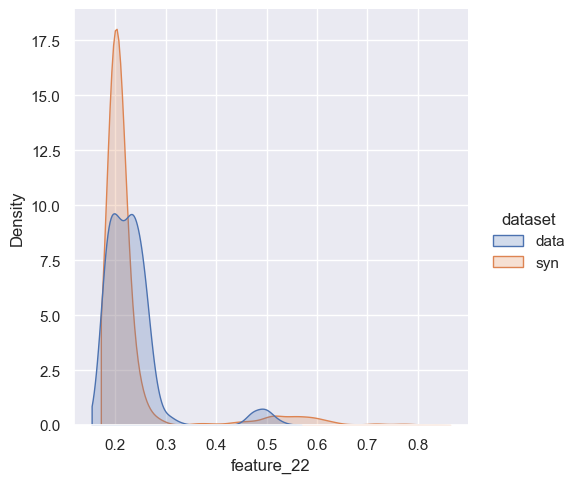
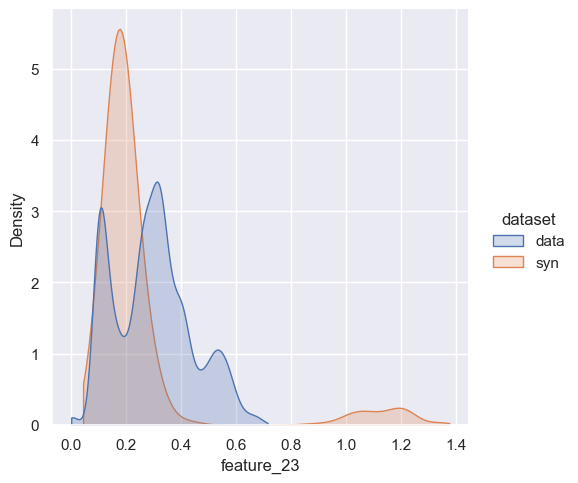
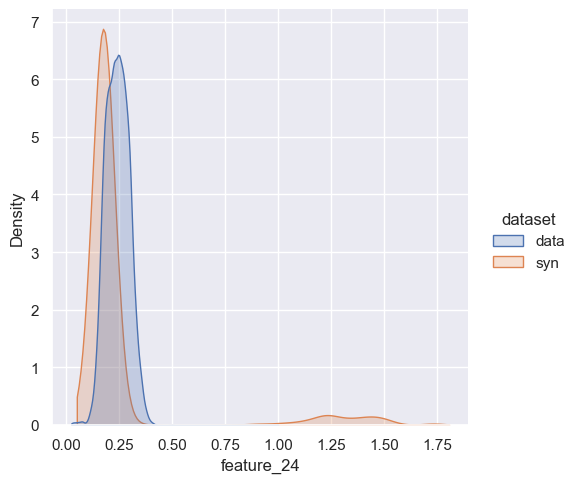

In [18]:
check.report([data,syn], config, output_file='rep.html')

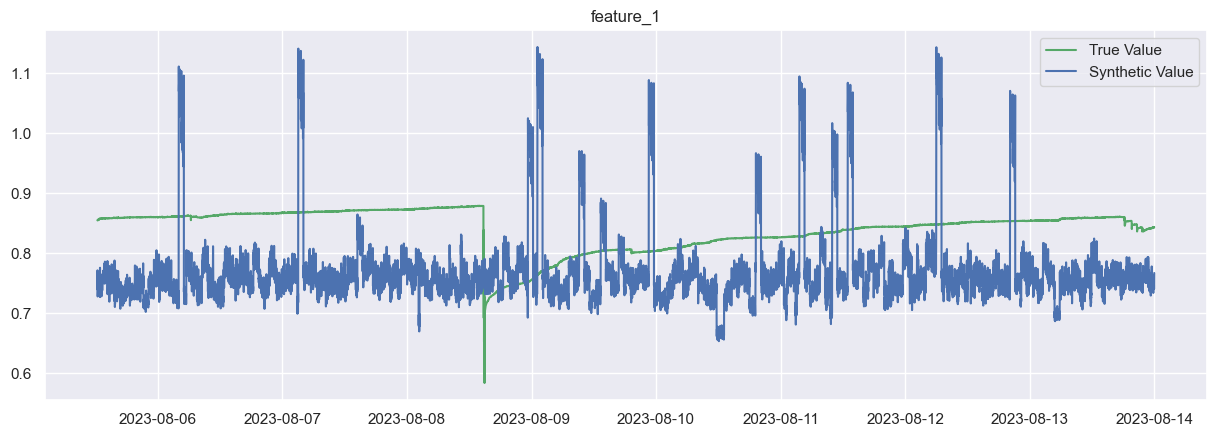

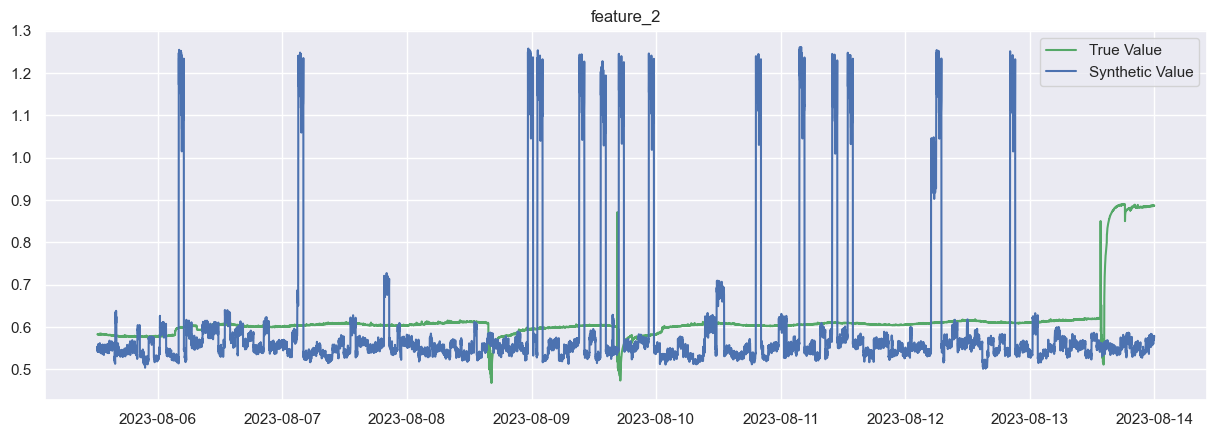

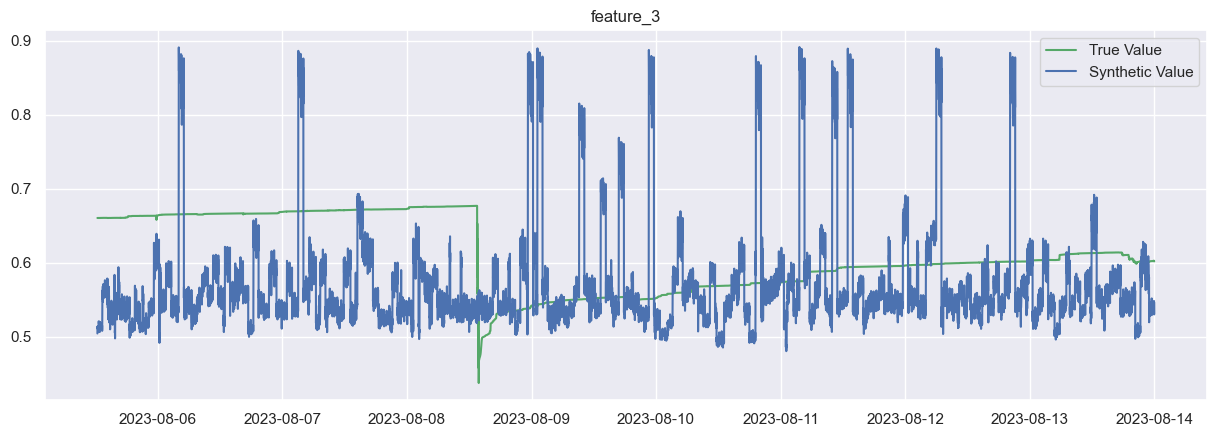

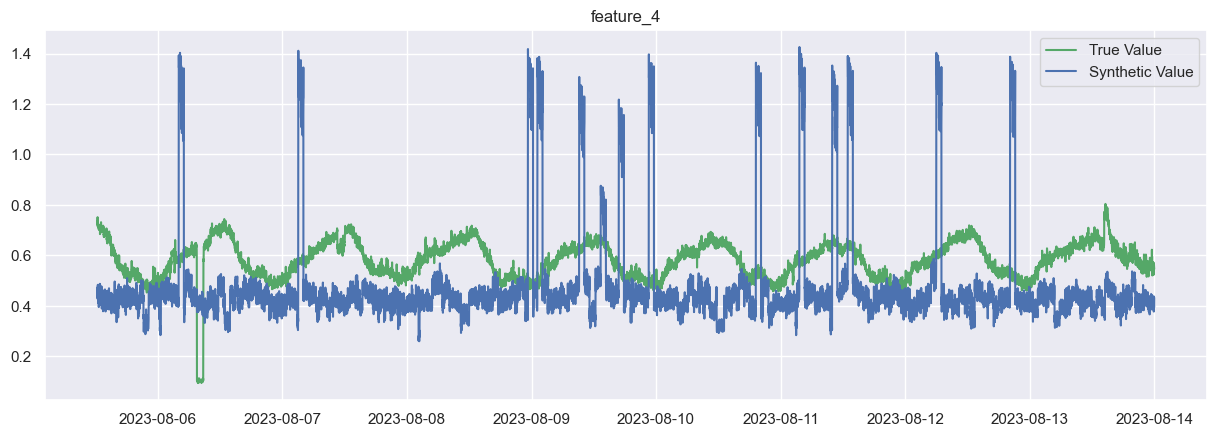

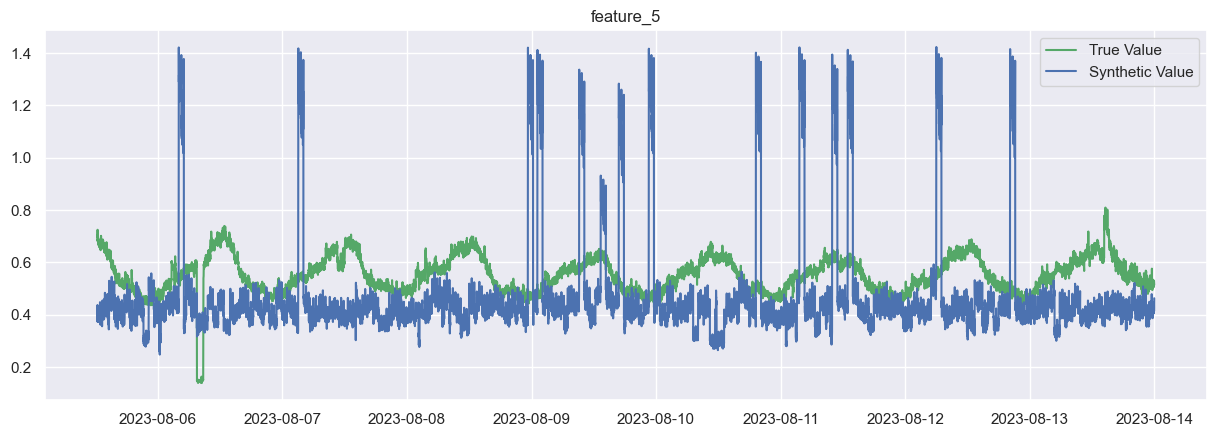

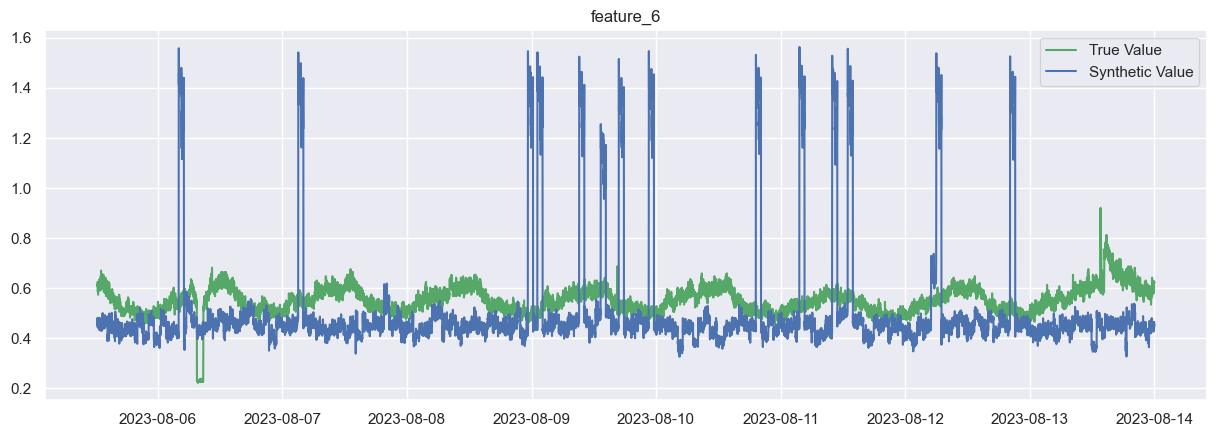

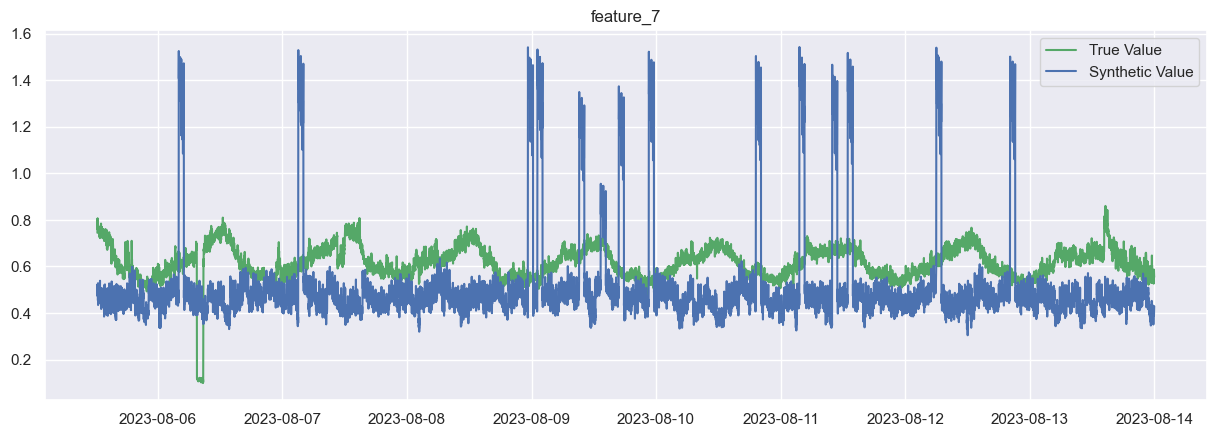

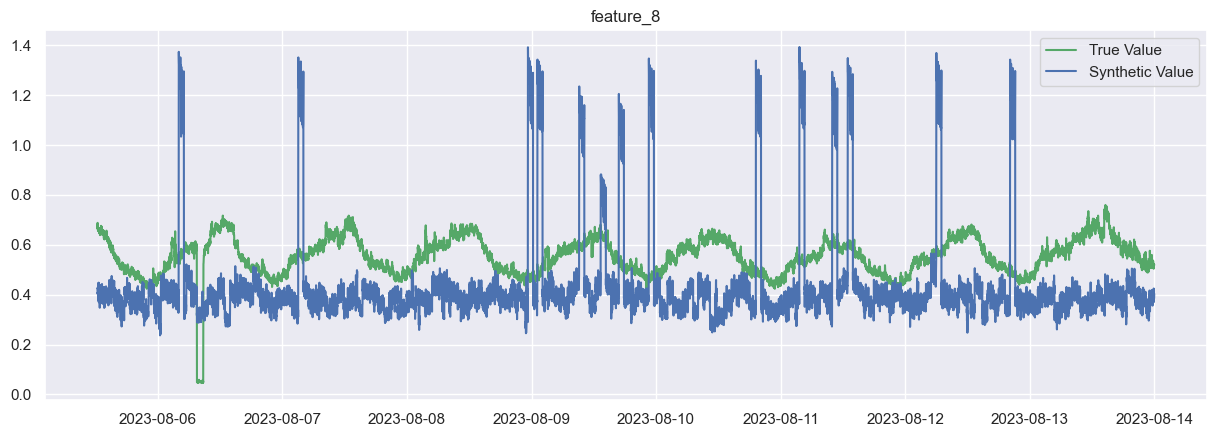

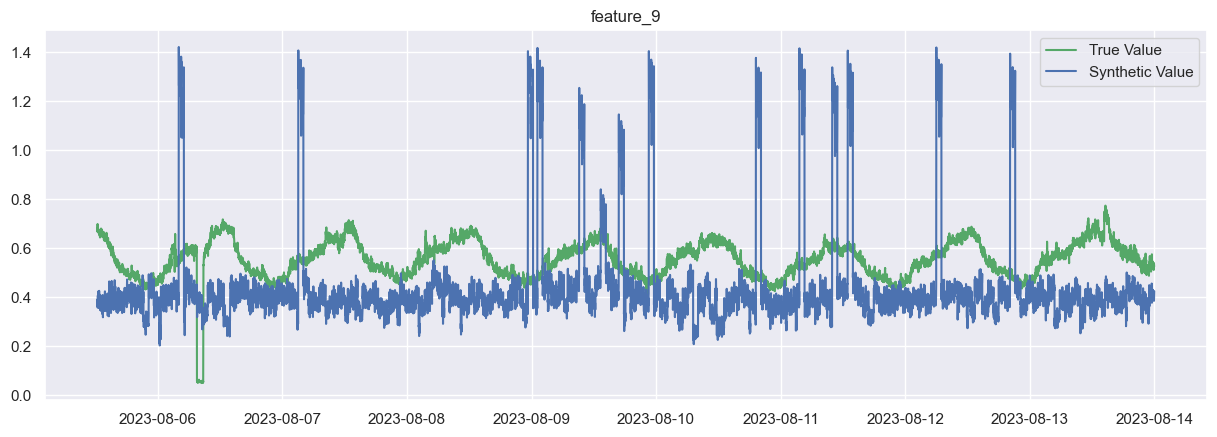

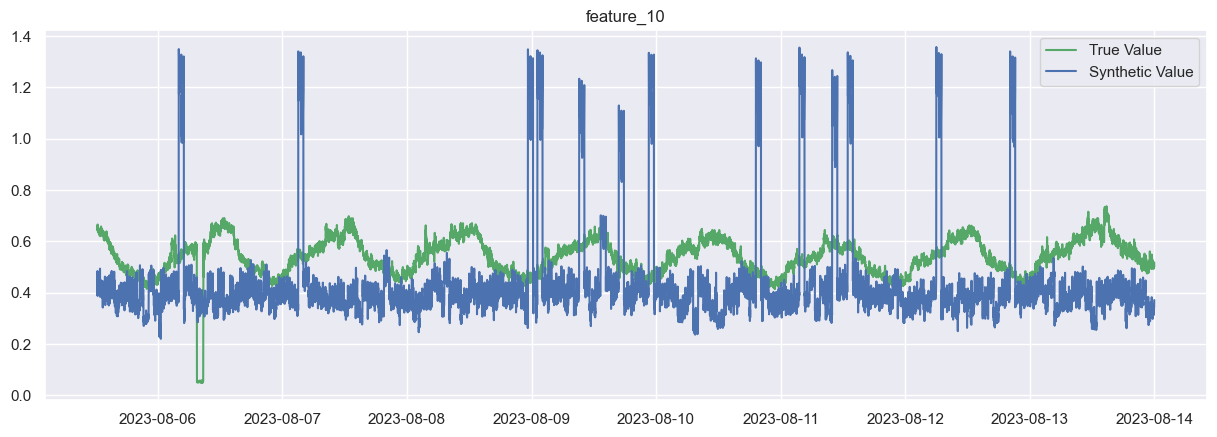

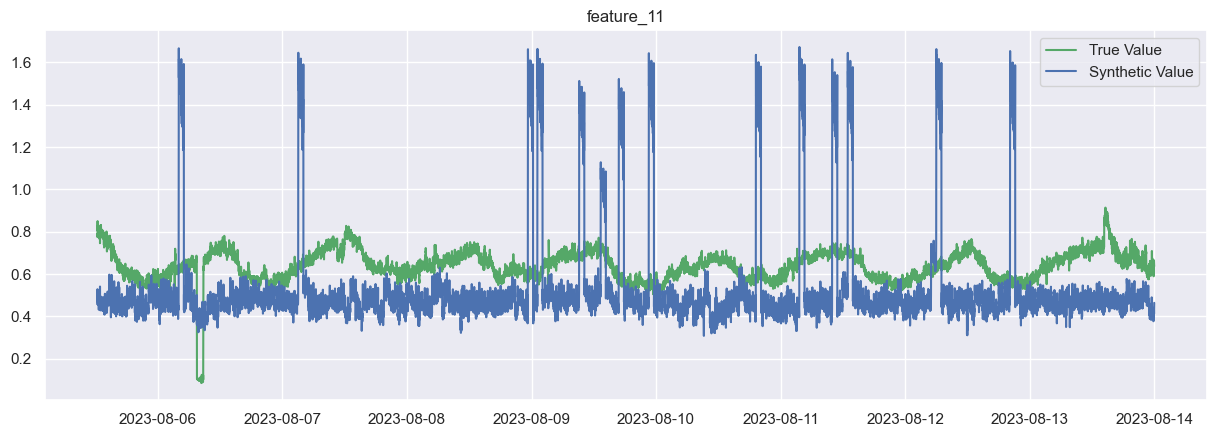

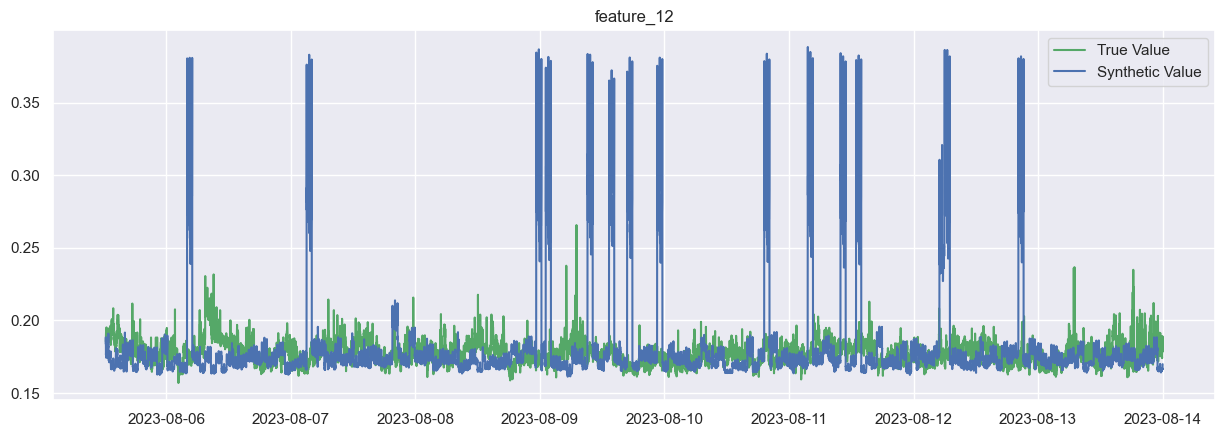

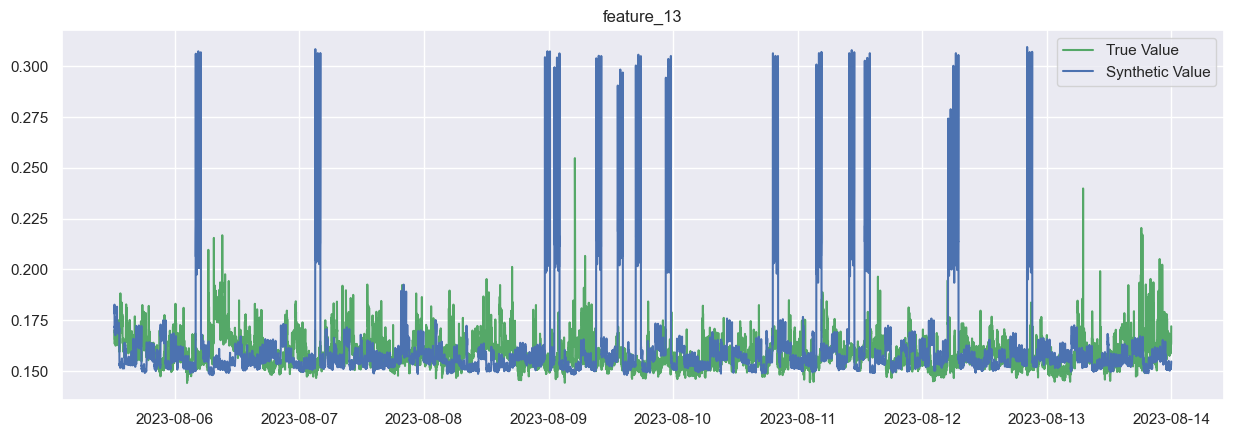

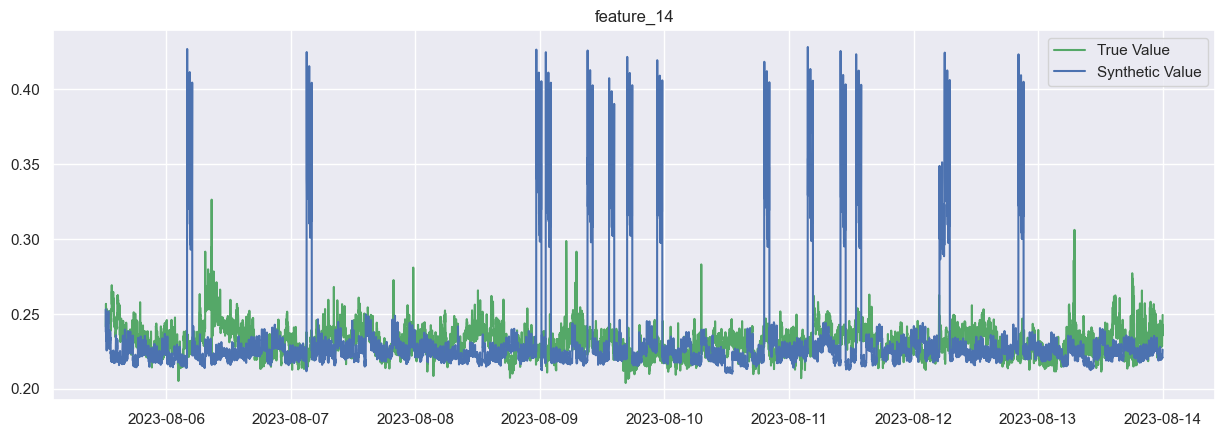

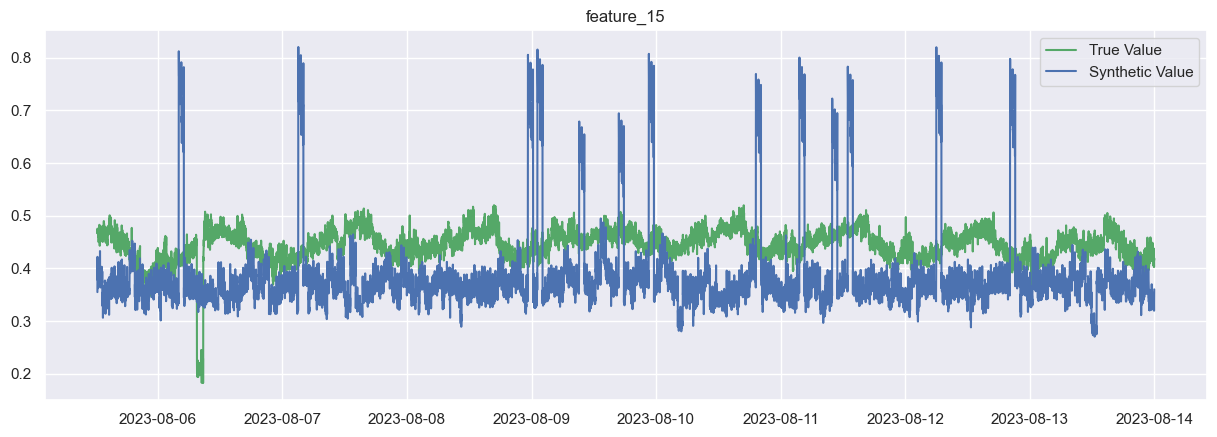

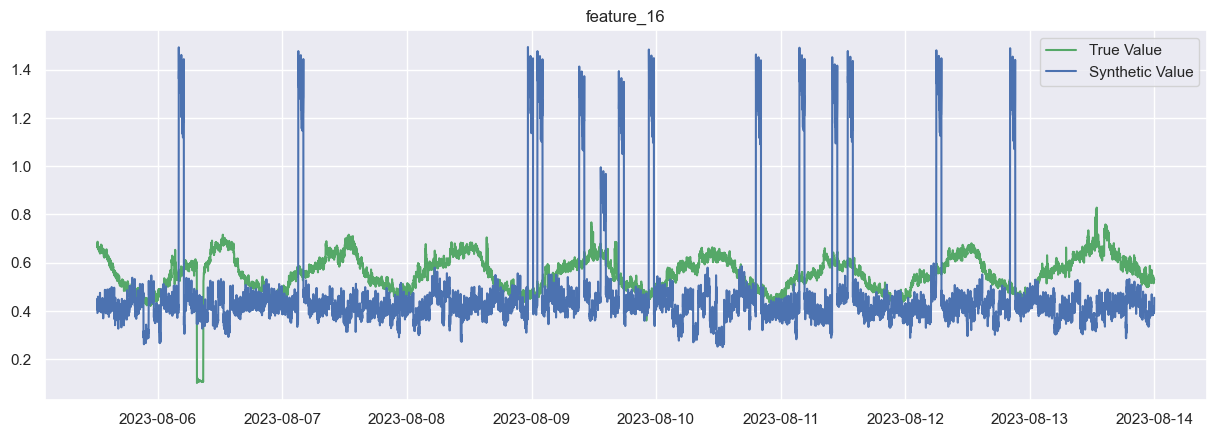

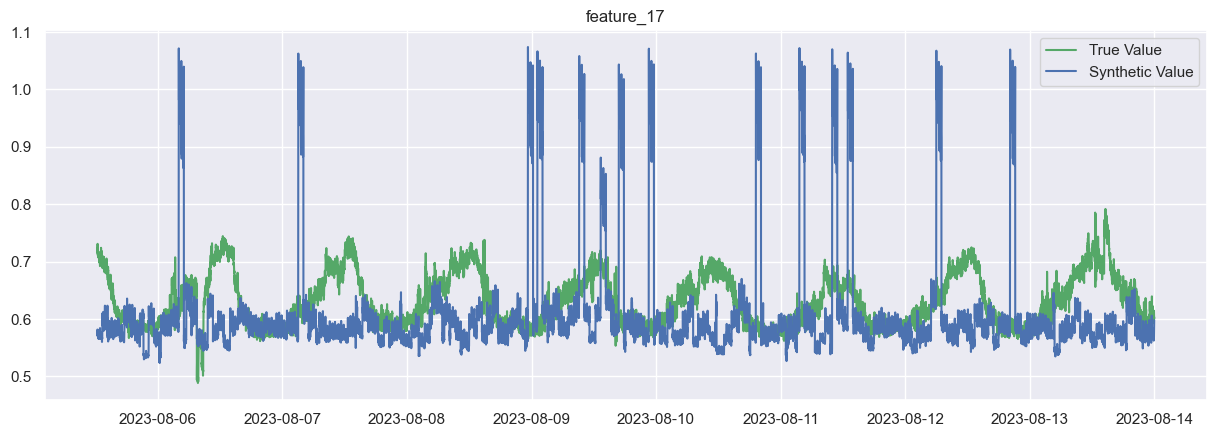

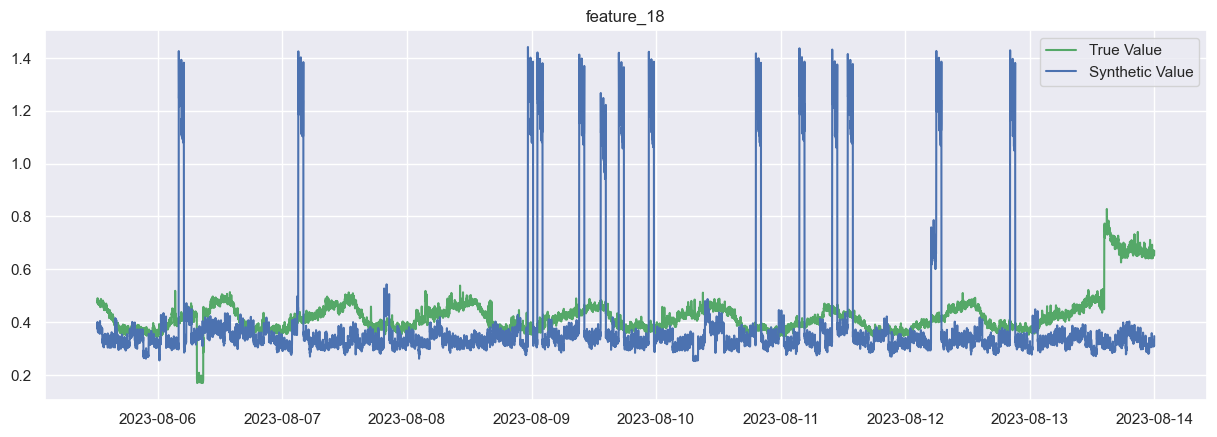

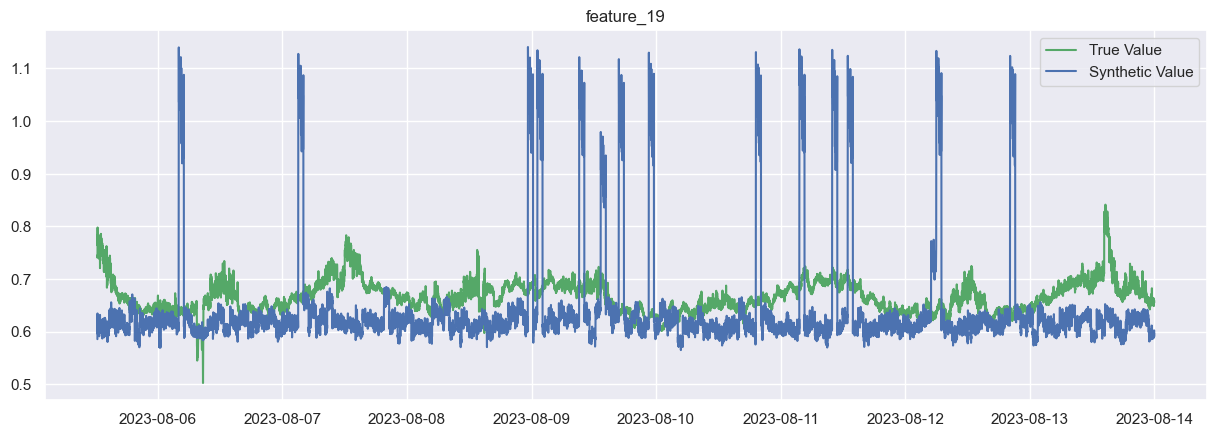

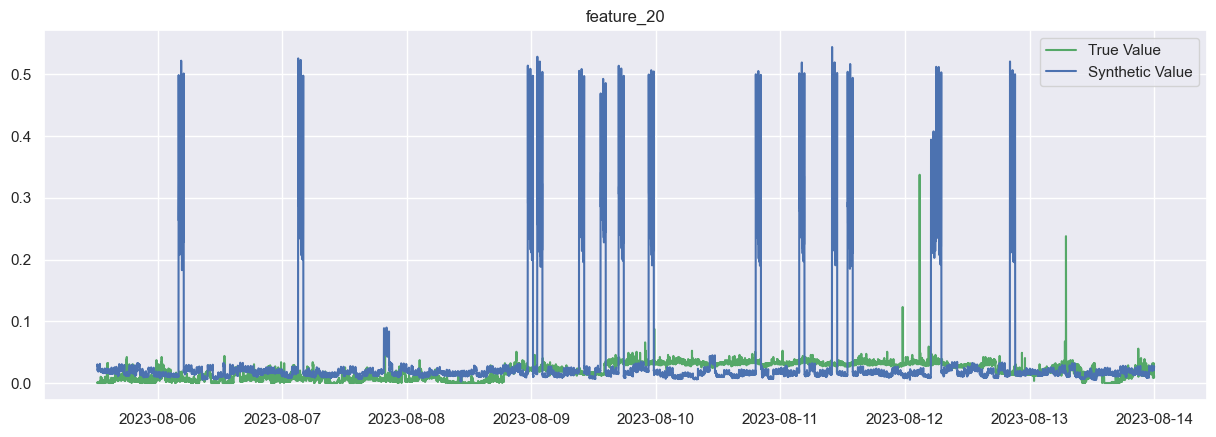

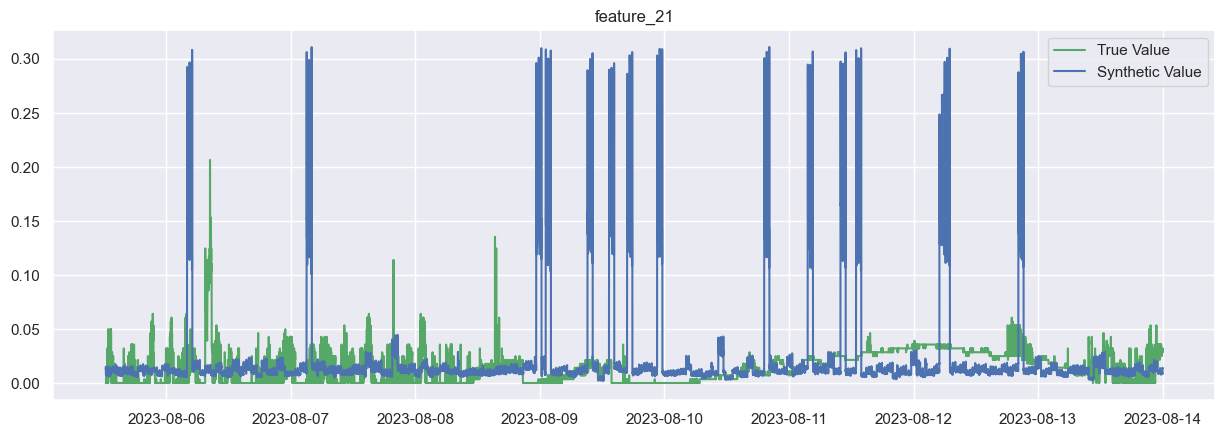

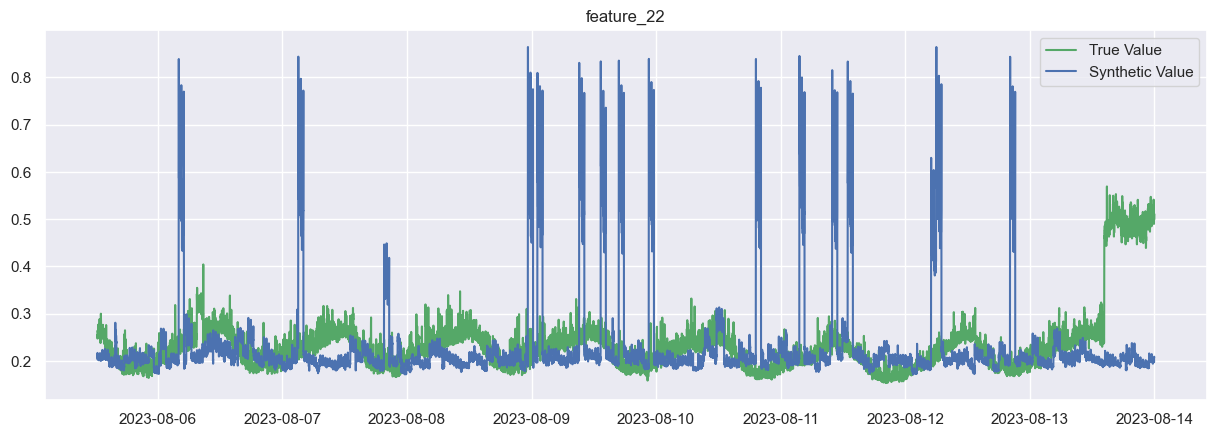

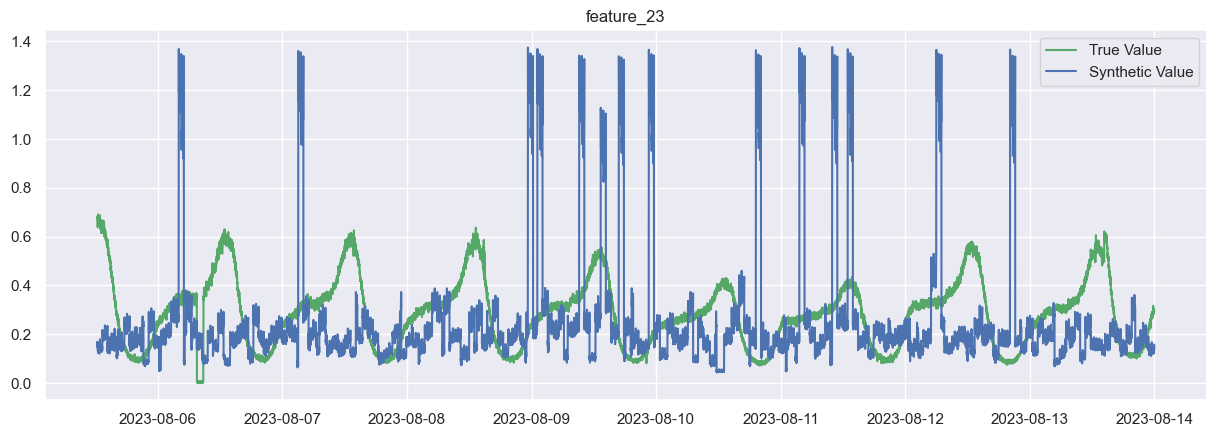

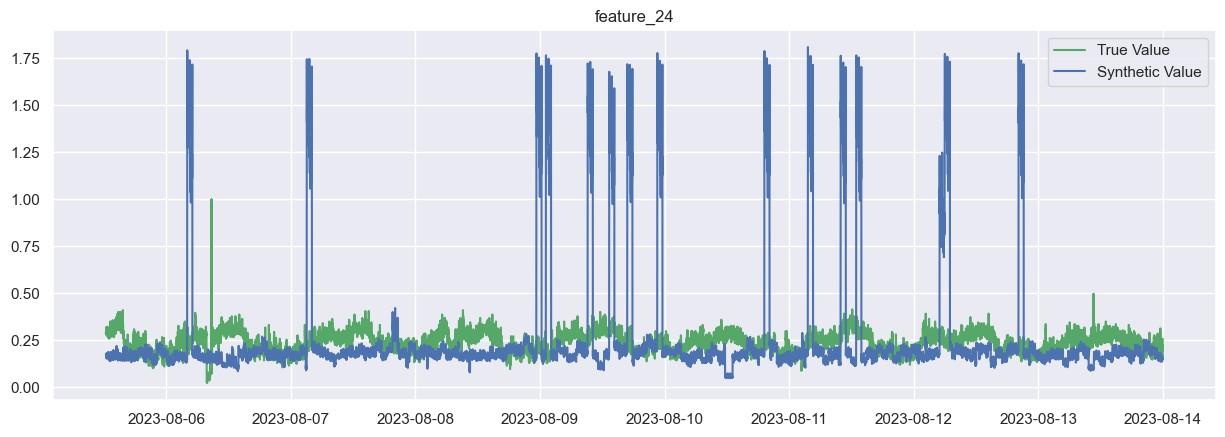

In [22]:
import matplotlib.pyplot as plt
for i in range(1,25):
    feature = f'feature_{i}'
    
    source_data = rf.Dataset.from_csv("source", "location3.csv")
    syn_data = rf.Dataset.from_csv("syn", "syn_data.csv")
    
    fig, ax = plt.subplots()
    fig.set_figwidth(15)
    x = source_data.table["timestamp"]
    y1 = source_data.table[feature]
    y2 = syn_data.table[feature]
    
    min_len = min(len(x), len(y1), len(y2))
    
    x = x[-min_len:]
    y1 = y1[-min_len:]
    y2 = y2[-min_len:]
    
    ax.plot(x, y1, "g", label="True Value")
    ax.plot(x, y2, "b", label="Synthetic Value")
    plt.title(feature)
    plt.legend()
    plt.show()